In [91]:
from scipy import misc 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mriSeg import *
%matplotlib inline

# construct an instance of mri segmentation
mri = misc.imread('img/ss_150.png')
seg = misc.imread('gt/seg_150.png')
train = MRI(mri, seg)

In [92]:
# perform bias correction
train.correct_bias(p_sub=0.1, # percentage of pixels sampled for bspline fitting 
                   K=6, # components of GMM  
                   spacing=50, # number of intervals for bspline fitting
                   Lambda=1, # penalty control factor
                   th_em=1e-6, # threshold for EM algorithm
                   th_c=1e-5, # threshold for updating bspline control points 
                   verbose=True # print training info 
                  )

# get log intensity of non-background
m = train.get_intensity()
m_c = train.get_intensity_bc()
x = m[m>1]
x_c = m_c[m_c>1]

EM finished. Total rounds:  262
cost:  7996.0558469
All finished. Total rounds:  1
cost:  7996.0558469


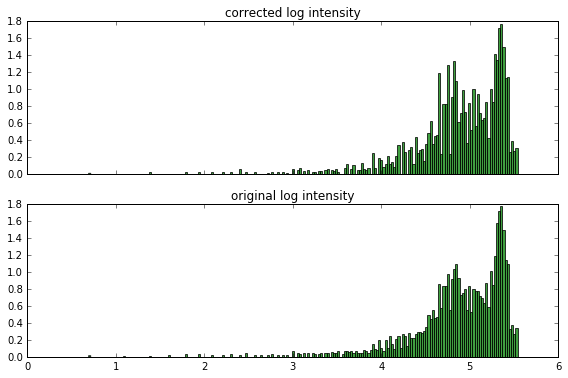

In [93]:
plt.rcParams["figure.figsize"] = [8.0, 8.0*2/3]

f, sub = plt.subplots(2, sharex=True)
sub[0].hist(np.log(x_c), 200, normed=1, color='green', alpha=0.75)
sub[0].set_title('corrected log intensity')
sub[1].hist(np.log(x), 200, normed=1, color='green', alpha=0.75)
sub[1].set_title('original log intensity')

plt.tight_layout()
plt.show()

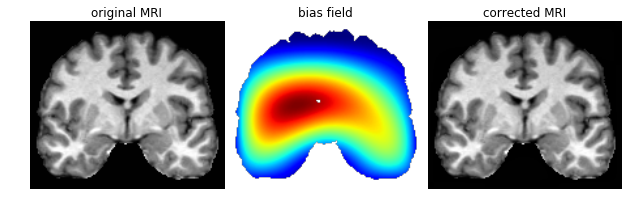

In [94]:
# get bias field and corrected image
bf = train.get_bias_field()
mri_bc = train.get_mri_bc()

sub1 = plt.subplot(131)
sub1.set_title('original MRI')
sub1.imshow(mri)
sub1.axis('off')

sub2 = plt.subplot(132)
sub2.set_title('bias field')
sub2.imshow(bf)
sub2.axis('off')

sub3 = plt.subplot(133)
sub3.set_title('corrected MRI')
sub3.imshow(mri_bc)
sub3.axis('off')

plt.tight_layout(pad=-2)
plt.show()

In [95]:
# segmentation with Gibbs Sampler
train.mrf_gs(C=2, # T = C/log(t+1) 
             c1=80, c2=1, # alpha = c1*0.9^t + c2, weight of feature energy 
             beta=1, delta=[1,-1], # determines spatial energy
             iteration=50, verbose=True)

# segmentation with Belief Propagation
train.mrf_bp(C=2, 
             c1=80, c2=1, 
             beta=1, delta=[1,-1], 
             iteration=5)

# get predictions 
pred_gs = train.get_prediction_gs()
pred_bp = train.get_prediction_bp()

# ground truth
gt = train.get_label()

MRF Gibbs Sampling, round:  10
class means:  [ 194.18463546    0.58882878   66.78518519  121.02740098]
class variances:  [  7.11658619e+02   3.00305091e-01   5.58521886e+02   1.52594746e+02]
MRF Gibbs Sampling, round:  20
class means:  [ 202.3953807     0.57647749   68.56719653  129.10961326]
class variances:  [  4.44473934e+02   2.45324386e-01   6.17416727e+02   2.80593952e+02]
MRF Gibbs Sampling, round:  30
class means:  [ 204.08541071    0.57647749   71.2799067   132.09407588]
class variances:  [  3.96022537e+02   2.45324386e-01   6.57055941e+02   2.96755294e+02]
MRF Gibbs Sampling, round:  40
class means:  [ 204.88350731    0.57647749   73.14209031  133.86276715]
class variances:  [  3.74594363e+02   2.45324386e-01   6.85441130e+02   3.02891853e+02]
MRF Gibbs Sampling, round:  50
class means:  [ 205.3192389     0.57647749   74.31687117  134.77334542]
class variances:  [  3.64173774e+02   2.45324386e-01   7.12324439e+02   3.14997585e+02]
MRF Gibbs Sampling finished.
BP message updat

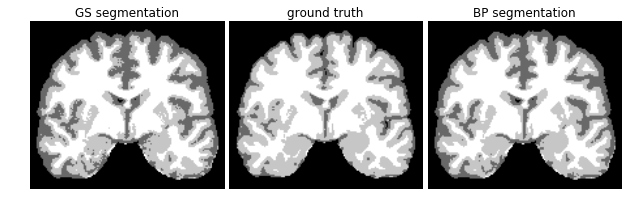

In [96]:
plt.rcParams["figure.figsize"] = [8.0, 8.0*2/3]

sub1 = plt.subplot(131)
sub1.set_title('GS segmentation')
sub1.imshow(pred_gs, cmap='Greys_r')
sub1.axis('off')

sub2 = plt.subplot(132)
sub2.set_title('ground truth')
sub2.imshow(gt, cmap='Greys_r')
sub2.axis('off')

sub3 = plt.subplot(133)
sub3.set_title('BP segmentation')
sub3.imshow(pred_bp, cmap='Greys_r')
sub3.axis('off')

plt.tight_layout(pad=-2)
plt.show()

In [97]:
print 'GS segmentation: '
print 'Tanimoto coefficient: ', train.evaluate()
print 'Dice coefficient: ', train.evaluate(coef='dice')

GS segmentation: 
Tanimoto coefficient:  [ 0.93263043  0.54874736  0.75821768  0.95365455]
Dice coefficient:  [ 0.96514099  0.70863379  0.86248442  0.97627756]


In [98]:
print 'BP segmentation: '
print 'Tanimoto coefficient: ', train.evaluate(method='bp')
print 'Dice coefficient: ', train.evaluate(method='bp', coef='dice')

BP segmentation: 
Tanimoto coefficient:  [ 0.93263043  0.60225017  0.81429355  0.95861504]
Dice coefficient:  [ 0.96514099  0.75175547  0.89764255  0.97887029]
